In [2946]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2947]:
import numpy as np
import matplotlib.pyplot as plt


from neuron_population import NeuronPopulation
from connectome import Connectome
from overhead import Simulation

In [2948]:
dt = 0.1

In [2949]:
# Neuron population parameters
layer_distribution = [2, 8, 2]
n_layers = 3
neuron_types = ["TRN", "p23", "nb"]
n_neuron_types = len(neuron_types)
inhibitory = [False, True, True]
dist_layer1 = np.array([1, 0, 0])
dist_layer2 = np.array([0, 6, 2])
dist_layer3 = np.array([1, 0, 0])
neuron_distribution = [dist_layer1, dist_layer2, dist_layer3]
threshold_decay = np.exp(-dt / 5)
layer_distances = np.zeros((n_layers, n_layers))
# mm
layer_distances[0, 0] = 0.6
layer_distances[1, 1] = 0.6
layer_distances[2, 2] = 0.6
layer_distances[0, 1] = 5.0
layer_distances[1, 0] = 5.0
layer_distances[1, 2] = 5.0
layer_distances[2, 1] = 5.0
layer_distances[0, 2] = 10.0
layer_distances[2, 0] = 10.0

In [2950]:
neuron_pop = NeuronPopulation(
    layer_distribution,
    neuron_distribution,
    layer_distances,
    neuron_types,
    inhibitory,
    threshold_decay,
    threshold_mult=1.15
)

In [2951]:
# Connectome
max_synapses = 8
synapse_strength = np.ones((n_layers, n_layers))
# neuron_types = ["p23", "TRN", "b", "nb"]
connectivity_probability = np.ones((n_layers, n_layers, n_neuron_types, n_neuron_types+2))


connectivity_probability[:,:,:,-2] = 0.0  # Self connections
connectivity_probability[:,:,:,-1] = 0.0  # No empty connections
# No inter-connections for input and output layers
connectivity_probability[0, 0, :, :-2] = 0
connectivity_probability[2, 2, :, :-2] = 0
# Only flow in one direction
connectivity_probability[1, 0, :, :-2] = 0.0
connectivity_probability[2, 1, :, :-2] = 0.0
connectivity_probability[2, 0, :, :-2] = 0.0

In [2952]:
connectome = Connectome(
    max_synapses,
    neuron_pop,
    connectivity_probability,
    synapse_strength,
)

In [2953]:
connectome.M

array([[ 2,  9, 10,  8,  2,  9,  5,  2],
       [10,  7,  7,  7,  6,  3, 11, 10],
       [ 9,  6, 10,  9,  7, 11,  5, 11],
       [ 9,  4,  9,  9,  9,  4,  6,  6],
       [ 5,  2,  9,  2,  2,  6,  7,  7],
       [ 3, 10,  2,  9,  6,  9,  2,  9],
       [10,  2,  3,  3,  2,  8,  3, 11],
       [ 4,  6,  6,  5, 10,  9,  5,  8],
       [ 6,  3,  6,  6,  6,  6,  5,  5],
       [ 6,  4,  8,  3,  8,  8,  6,  4],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [2954]:
# connectome.distances

In [2955]:
sim = Simulation(connectome, dt, stepper_type="adapt")

In [2956]:
weights_t0 = connectome.W.copy()

In [2957]:
connectome.W.copy()

array([[1.2988028 , 1.02377205, 1.84046062, 2.23227984, 1.0133207 ,
        0.0402465 , 1.59752354, 1.0627039 ],
       [0.62481214, 1.59743851, 1.25628308, 1.39397717, 0.6768585 ,
        1.0414135 , 0.67950301, 1.51131249],
       [0.29627879, 0.8514966 , 1.68649744, 1.01876084, 0.97162253,
        1.69881795, 1.056881  , 0.2157241 ],
       [1.20151758, 0.75879779, 1.81741162, 0.81122566, 1.98612607,
        0.55685939, 0.70248554, 0.12434599],
       [1.28268788, 0.92988017, 0.03672527, 0.64166448, 1.21653096,
        0.48072334, 0.87194273, 1.12378317],
       [1.16564149, 0.9981144 , 1.14063369, 1.36586569, 0.2011059 ,
        0.67105643, 0.85272589, 1.01271175],
       [0.64952046, 1.29312641, 1.21463898, 1.14361447, 1.74136121,
        2.05862055, 0.86663101, 1.62400888],
       [1.58732557, 1.26771744, 0.        , 1.02048615, 1.72361502,
        0.8315294 , 0.94126146, 1.670102  ],
       [0.76674098, 1.27930135, 0.1007322 , 1.25371399, 1.61363769,
        0.71345326, 0.655685

In [2958]:
I_ext = np.zeros((neuron_pop.n_neurons))
I_ext[0] = 100
I_ext[-2] = 0

# I_ext = 100

for i in range(10000):
    sim.step(I_ext=I_ext)
    # print(sim.synapse_dynamics.g_ST)
    # if np.sum(sim.pre_spikes) > 0:
        # print(f"Step {i}, {sim.t_now}, heap size: {(sim.axonal_dynamics._heap)}")
        # print(sim.pre_spikes)

weights_t1 = connectome.W.copy()

In [2959]:
sim.synapse_dynamics.g_ST

array([0.00000000e+00, 0.00000000e+00, 1.11631645e+02, 2.36988698e+02,
       4.24976634e+05, 1.24002524e+02, 2.88918270e+02, 7.71930711e+01,
       8.91695658e+01, 3.85687621e+02, 2.89089283e+02, 1.67954811e+03])

In [2960]:
neuron_pop.inhibitory_mask

array([False, False,  True,  True,  True,  True,  True,  True,  True,
        True, False, False])

In [2961]:
sim.neuron_states.V

array([-63.82272857, -60.        , -82.01723498, -83.84787697,
       -30.71962861, -80.3069687 , -82.93357464, -78.05478995,
       -81.23008056, -83.7209163 ,  -1.28931996, -55.        ])

In [2962]:
weights_t1[neuron_pop.inhibitory_mask]

array([[2.08606659e-01, 1.25783126e+00, 1.12958763e+00, 7.17298377e-01,
        2.28793687e-01, 1.50647096e+01, 4.98351529e-01, 1.91298951e+00],
       [8.45975401e-01, 2.49505240e+03, 1.27961966e+00, 5.71175122e-01,
        1.39840966e+00, 1.83104559e+03, 1.03771204e+00, 1.83683974e-01],
       [6.04826338e-01, 2.08951036e-01, 2.58578622e-02, 1.44186813e-01,
        2.73363615e-01, 7.10124792e-01, 2.05321497e-01, 2.64623849e-01],
       [1.11930131e+00, 6.68520248e-01, 2.56308930e-01, 9.61691104e-01,
        2.97073755e-01, 4.72483499e-01, 1.91613892e-01, 7.13039279e-01],
       [4.35037884e-01, 2.90575186e-01, 1.16635090e+00, 1.09814998e+00,
        3.91296903e-01, 6.97091663e-01, 8.32178011e-01, 1.44013206e+01],
       [5.21938851e+03, 1.87267292e+00, 0.00000000e+00, 4.81190247e-01,
        1.15444837e+00, 5.85470766e-01, 4.43833399e-01, 5.65531215e-01],
       [1.13263021e+00, 1.22844261e+00, 1.48801670e-01, 1.85198702e+00,
        2.38366652e+00, 1.05391356e+00, 3.09175834e-01, 6.

In [2963]:
weights_t1 -   weights_t0

array([[-1.03069334e+00, -3.53486947e-01, -2.55319877e-01,
        -1.53562612e+00, -8.04142778e-01, -1.38962700e-02,
        -9.00876465e-01, -8.43331902e-01],
       [-2.06323471e-01, -1.22128024e+00, -9.60458698e-01,
        -1.06572915e+00,  3.22997259e-01, -4.14014875e-02,
         5.34616644e+00, -4.99060789e-01],
       [-8.76721320e-02,  4.06334662e-01, -5.56909804e-01,
        -3.01462466e-01, -7.42828845e-01,  1.33658916e+01,
        -5.58529474e-01,  1.69726541e+00],
       [-3.55542183e-01,  2.49429360e+03, -5.37791958e-01,
        -2.40050537e-01, -5.87716408e-01,  1.83048873e+03,
         3.35226501e-01,  5.93379795e-02],
       [-6.77861543e-01, -7.20929130e-01, -1.08674091e-02,
        -4.97477667e-01, -9.43167343e-01,  2.29401452e-01,
        -6.66621235e-01, -8.59159317e-01],
       [-4.63401824e-02, -3.29594154e-01, -8.84324757e-01,
        -4.04174583e-01,  9.59678516e-02, -1.98572931e-01,
        -6.61111997e-01, -2.99672475e-01],
       [-2.14482573e-01, -1.002551

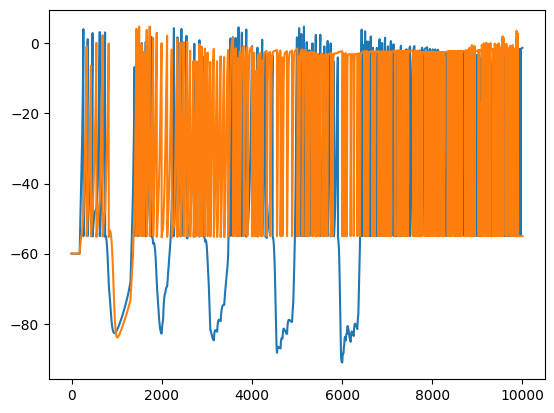

In [2965]:
plt.plot(np.array(sim.stats.Vs)[:, neuron_pop.get_neurons_from_layer(2)])
plt.show()